In [1]:
import os
import numpy as np
from six.moves import cPickle
import matplotlib.pyplot as plt
import helper

In [2]:

num_trials = 10
model_names = ['task2-cnn-shallow', 'task2-cnn-deep']# deep', 'cnn-25', 'cnn-4'] #
activations = ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']

results_path = os.path.join('../results', 'synthetic_code')
params_path = os.path.join(results_path, 'params')
save_path = os.path.join('..', 'scores')

In [3]:

# load data
data_path = '../data/Synthetic_code_dataset.h5'
data = helper.load_dataset(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = helper.load_synthetic_models(data_path, dataset='test')
true_index = np.where(y_test[:,0] == 1)[0]
X = x_test[true_index][:500]
X_model = test_model[true_index][:500]

In [4]:

score_names = ['saliency_scores1', 'saliency_scores2', 'mut_scores1', 
         'mut_scores2', 'smoothgrad_scores', 'integrated_scores', 'shap_scores']

results = {}
for model_name in model_names:
    for activation in activations:
        name = model_name+'_'+activation
        print(name)
        results[name] = {}
            
        file_path = os.path.join(save_path, name+'.pickle')
        with open(file_path, 'rb') as f:            
            saliency_scores1 = cPickle.load(f)
            saliency_scores2 = cPickle.load(f)
            mut_scores1 = cPickle.load(f)
            mut_scores2 = cPickle.load(f)
            smoothgrad_scores = cPickle.load(f)
            integrated_scores = cPickle.load(f)

        file_path = os.path.join(save_path, name+'_shap.pickle')
        with open(file_path, 'rb') as f:
            shap_scores = cPickle.load(f)

        all_scores = [saliency_scores1, saliency_scores2, mut_scores1, 
                      mut_scores2, smoothgrad_scores, integrated_scores, shap_scores]

        for score_name, scores in zip(score_names, all_scores):
            shap_roc = []
            shap_pr = []
            for trial in range(num_trials):
                if 'mut' in score_name:
                    trial_scores = np.sqrt(np.sum(scores[trial]**2, axis=-1, keepdims=True)) * X
                else:
                    trial_scores = scores[trial] * X
                roc_score, pr_score = helper.interpretability_performance(X, trial_scores, X_model)
                shap_roc.append(np.mean(roc_score))
                shap_pr.append(np.mean(pr_score))    
                
            results[name][score_name] = [np.array(shap_roc), np.array(shap_pr)]
            print('%s: %.4f+/-%.4f\t'%(name+'_'+score_name, 
                                       np.mean(results[name][score_name][0]), 
                                       np.std(results[name][score_name][0]))) 
            
            

task2-cnn-shallow_relu
task2-cnn-shallow_relu_saliency_scores1: 0.7644+/-0.0161	


KeyboardInterrupt: 

In [11]:

# save results
file_path = os.path.join(results_path, 'attr_results.pickle')
with open(file_path, 'wb') as f:
    cPickle.dump(results, f, protocol=cPickle.HIGHEST_PROTOCOL)


# Print results table

In [5]:
# save results
file_path = os.path.join(results_path, 'attr_results.pickle')
with open(file_path, 'rb') as f:
    results = cPickle.load(f)
    

In [6]:
score_names = ['saliency_scores1', 'mut_scores1', 'smoothgrad_scores', 
               'integrated_scores', 'shap_scores']

save_path = os.path.join(results_path, 'task2_attr_results_auroc.tsv')
with open(save_path, 'w') as f:
    for model_name in model_names:
        for activation in activations:
            name = model_name+'_'+activation
            f.write('%s\t'%(name)) 
            for score_name in score_names:
                f.write('%.4f+/-%.4f\t'%(np.mean(results[name][score_name][0]), 
                                         np.std(results[name][score_name][0])))
            f.write('\n')
            
save_path = os.path.join(results_path, 'task2_attr_results_aupr.tsv')
with open(save_path, 'w') as f:
    for model_name in model_names:
        for activation in activations:
            name = model_name+'_'+activation
            f.write('%s\t'%(name)) 
            for score_name in score_names:
                f.write('%.4f+/-%.4f\t'%(np.mean(results[name][score_name][1]), 
                                         np.std(results[name][score_name][1])))
            f.write('\n')
            
            

# PLOT COMPARISON

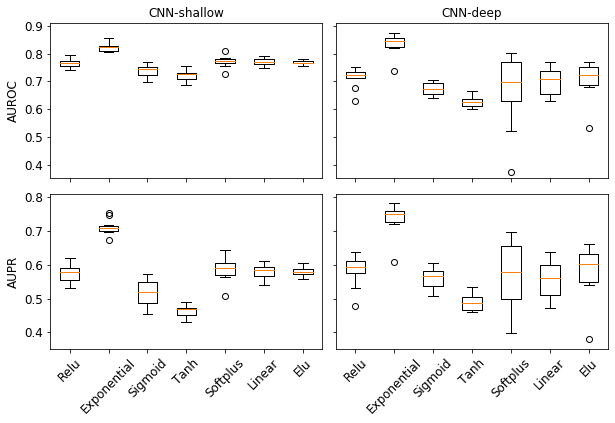

In [6]:
fig = plt.figure(figsize=(10,6))
plt.subplots_adjust(wspace=0.05, hspace=0.1)
activation_names = ['Relu', 'Exponential', 'Sigmoid', 'Tanh', 'Softplus', 'Linear', 'Elu']


ax = plt.subplot(2,2,1)
score_name = 'saliency_scores1'
model_name = 'task2-cnn-shallow'
vals = []
for activation in activations:
    name = model_name+'_'+activation
    vals.append(results[name][score_name][0])
    
ax.boxplot(vals);
plt.ylabel('AUROC', fontsize=12)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=12)
plt.xticks(range(1,8), activations, fontsize=12, rotation=45)
ax.set_ybound([.35,0.91])
ax.tick_params(labelbottom=False) 
plt.title('CNN-shallow', fontsize=12)

ax = plt.subplot(2,2,2)
model_name = 'task2-cnn-deep'
vals2 = []
for activation in activations:
    name = model_name+'_'+activation
    vals2.append(results[name][score_name][0])
    
ax.boxplot(vals2);
ax.tick_params(labelleft=False) 
ax.tick_params(labelbottom=False) 
#plt.xticks(range(1,8), activations, fontsize=12, rotation=45);
ax.set_ybound([.35,0.91])
plt.title('CNN-deep', fontsize=12)


ax = plt.subplot(2,2,3)
score_name = 'saliency_scores1'
model_name = 'task2-cnn-shallow'
vals = []
for activation in activations:
    name = model_name+'_'+activation
    vals.append(results[name][score_name][1])
    
ax.boxplot(vals);
plt.ylabel('AUPR', fontsize=12)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=12)
plt.xticks(range(1,8), activation_names, fontsize=12, rotation=45)
ax.set_ybound([.35,0.81])
#plt.title('CNN-shallow', fontsize=12)

ax = plt.subplot(2,2,4)
model_name = 'task2-cnn-deep'
vals2 = []
for activation in activations:
    name = model_name+'_'+activation
    vals2.append(results[name][score_name][1])
    
ax.boxplot(vals2);
ax.tick_params(labelleft=False) 
plt.xticks(range(1,8), activation_names, fontsize=12, rotation=45);
ax.set_ybound([.35,0.81])
#plt.title('CNN-deep', fontsize=12)
outfile = os.path.join(results_path, 'task2_compare_attr_score_activations.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

In [17]:

# save results
file_path = os.path.join(results_path, 'code_performance.pickle')
with open(file_path, 'rb') as f:
    performance = cPickle.load(f)

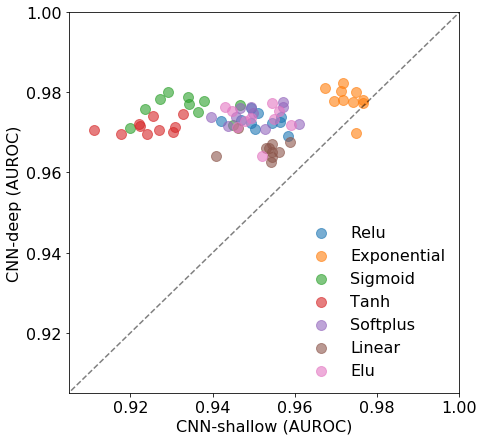

In [37]:


fig = plt.figure(figsize=(7,7))
for activation in activations:
    name = 'task2-cnn-shallow_do_l2_bn_'+activation
    name2 = 'task2-cnn-deep_do_l2_bn_'+activation
    ax = plt.scatter(performance[name][0], performance[name2][0], alpha=0.6, s=100)
plt.legend(activation_names, fontsize=16, frameon=False)
plt.plot([0.9, 1.0], [0.90, 1.0], '--k', alpha=0.5)
plt.xticks([0.92, 0.94, 0.96, 0.98, 1.], fontsize=16)
plt.yticks([0.92, 0.94, 0.96, 0.98, 1.], fontsize=16)
plt.ylim(0.905, 1.0)
plt.xlim(0.905, 1.0)
plt.xlabel('CNN-shallow (AUROC)', fontsize=16)
plt.ylabel('CNN-deep (AUROC)', fontsize=16)
outfile = os.path.join(results_path, 'task2_compare_cnn_attr_score_performance.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

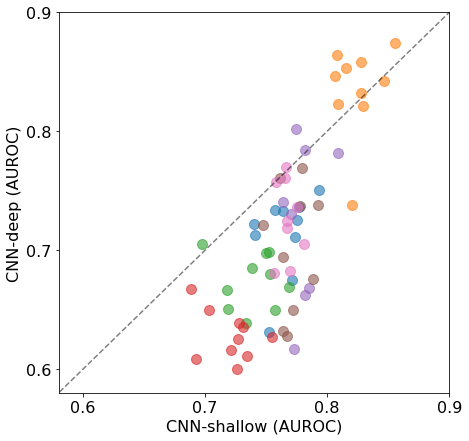

In [22]:
score_name = 'saliency_scores1'
model_name = 'task2-cnn-shallow'
vals = []
for activation in activations:
    name = model_name+'_'+activation
    vals.append(results[name][score_name][0])
    
model_name = 'task2-cnn-deep'
vals2 = []
for activation in activations:
    name = model_name+'_'+activation
    vals2.append(results[name][score_name][0])

fig = plt.figure(figsize=(7,7))
for i in range(len(vals)):
    ax = plt.scatter(vals[i], vals2[i], alpha=0.6, s=100)
#plt.legend(activations, fontsize=16, frameon=False)
plt.plot([0.35, 0.9], [0.35, 0.9], '--k', alpha=0.5)
plt.xticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=16)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=16)
plt.ylim(0.58, 0.9)
plt.xlim(0.58, 0.9)
plt.xlabel('CNN-shallow (AUROC)', fontsize=16)
plt.ylabel('CNN-deep (AUROC)', fontsize=16)
outfile = os.path.join(results_path, 'task2_compare_cnn_attr_score_roc.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

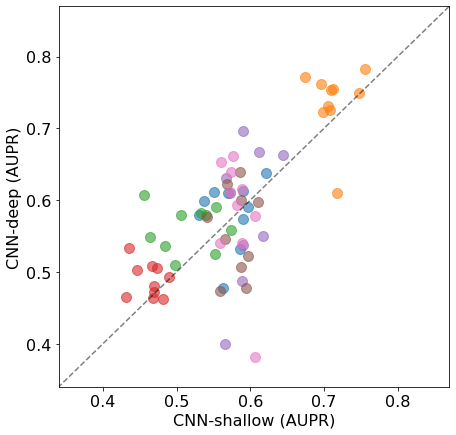

In [21]:
score_name = 'saliency_scores1'
model_name = 'task2-cnn-shallow'
vals = []
for activation in activations:
    name = model_name+'_'+activation
    vals.append(results[name][score_name][1])
    
model_name = 'task2-cnn-deep'
vals2 = []
for activation in activations:
    name = model_name+'_'+activation
    vals2.append(results[name][score_name][1])

fig = plt.figure(figsize=(7,7))
for i in range(len(vals)):
    ax = plt.scatter(vals[i], vals2[i], alpha=0.6, s=100)
#plt.legend(activations, fontsize=16, frameon=False)
plt.plot([0.3, 0.9], [0.3, 0.9], '--k', alpha=0.5)
plt.xticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=16)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=16)
plt.ylim(0.34, 0.87)
plt.xlim(0.34, 0.87)
plt.xlabel('CNN-shallow (AUPR)', fontsize=16)
plt.ylabel('CNN-deep (AUPR)', fontsize=16)
outfile = os.path.join(results_path, 'task2_compare_cnn_attr_score_pr.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

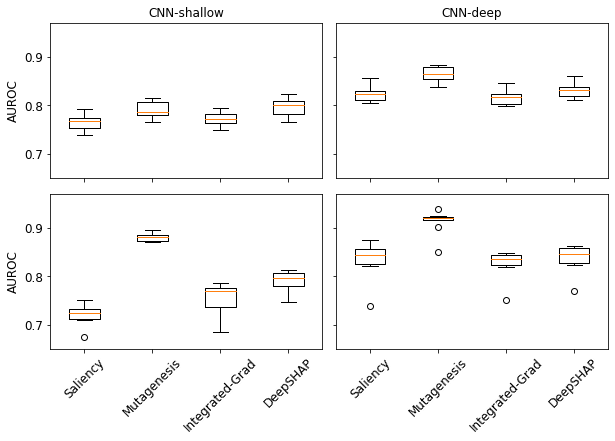

In [32]:

score_names = ['saliency_scores1', 'mut_scores1', 'integrated_scores', 'shap_scores']
names = ['Saliency', 'Mutagenesis', 'Integrated-Grad', 'DeepSHAP']
activations = ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']

fig = plt.figure(figsize=(10,6))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

ax = plt.subplot(2,2,1)
score_name = 'saliency_scores1'
model_name = 'task2-cnn-shallow'
vals = []
for score_name in score_names:
    name = model_name+'_relu'
    vals.append(results[name][score_name][0])    
ax.boxplot(vals);
plt.ylabel('AUROC', fontsize=12)
plt.yticks([0.7, 0.8, 0.9, 1.0], fontsize=12)
plt.xticks(range(1,5), names, fontsize=12, rotation=45)
ax.set_ybound([.65,.97])
ax.tick_params(labelbottom=False) 
plt.title('CNN-shallow', fontsize=12)

ax = plt.subplot(2,2,2)

model_name = 'task2-cnn-shallow'
vals = []
for score_name in score_names:
    name = model_name+'_exponential'
    vals.append(results[name][score_name][0])
ax.boxplot(vals);
#plt.ylabel('AUROC', fontsize=12)
plt.yticks([0.7, 0.8, 0.9, 1.0], fontsize=12)
plt.xticks(range(1,5), names, fontsize=12, rotation=45)
ax.set_ybound([.65,.97])
ax.tick_params(labelleft=False) 
ax.tick_params(labelbottom=False) 
#plt.xticks(range(1,8), activations, fontsize=12, rotation=45);
plt.title('CNN-deep', fontsize=12)


ax = plt.subplot(2,2,3)

model_name = 'task2-cnn-deep'
vals = []
for score_name in score_names:
    name = model_name+'_relu'
    vals.append(results[name][score_name][0])
ax.boxplot(vals);
plt.yticks([0.7, 0.8, 0.9, 1.0], fontsize=12)
plt.xticks(range(1,5), names, fontsize=12, rotation=45)
plt.ylabel('AUROC', fontsize=12)
ax.set_ybound([.65,.97])
#plt.title('CNN-shallow', fontsize=12)

ax = plt.subplot(2,2,4)

model_name = 'task2-cnn-deep'
vals = []
for score_name in score_names:
    name = model_name+'_exponential'
    vals.append(results[name][score_name][0])
ax.boxplot(vals);
#plt.ylabel('AUPR', fontsize=12)
plt.yticks([0.7, 0.8, 0.9, 1.0], fontsize=12)
plt.xticks(range(1,5), names, fontsize=12, rotation=45)
ax.tick_params(labelleft=False) 
ax.set_ybound([.65,.97])

#plt.title('CNN-deep', fontsize=12)
outfile = os.path.join(results_path, 'task2_compare_attr_methods_roc.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

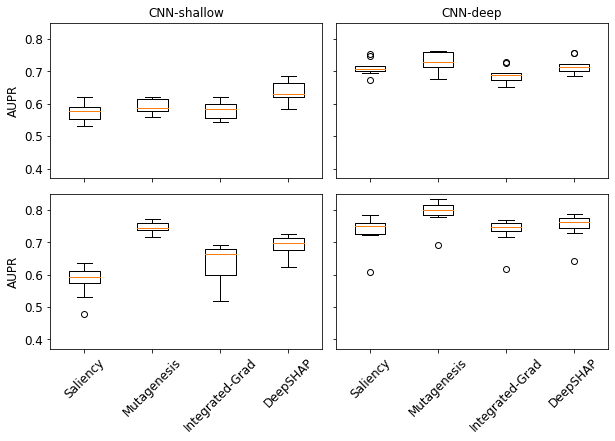

In [35]:

score_names = ['saliency_scores1', 'mut_scores1', 'integrated_scores', 'shap_scores']
names = ['Saliency', 'Mutagenesis', 'Integrated-Grad', 'DeepSHAP']
activations = ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']

fig = plt.figure(figsize=(10,6))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

ax = plt.subplot(2,2,1)
score_name = 'saliency_scores1'
model_name = 'task2-cnn-shallow'
vals = []
for score_name in score_names:
    name = model_name+'_relu'
    vals.append(results[name][score_name][1])    
ax.boxplot(vals);
plt.ylabel('AUPR', fontsize=12)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8], fontsize=12)
plt.xticks(range(1,5), names, fontsize=12, rotation=45)
ax.set_ybound([.37,.85])
ax.tick_params(labelbottom=False) 
plt.title('CNN-shallow', fontsize=12)

ax = plt.subplot(2,2,2)

model_name = 'task2-cnn-shallow'
vals = []
for score_name in score_names:
    name = model_name+'_exponential'
    vals.append(results[name][score_name][1])
ax.boxplot(vals);
#plt.ylabel('AUROC', fontsize=12)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8], fontsize=12)
plt.xticks(range(1,5), names, fontsize=12, rotation=45)
ax.set_ybound([.37,.85])
ax.tick_params(labelleft=False) 
ax.tick_params(labelbottom=False) 
#plt.xticks(range(1,8), activations, fontsize=12, rotation=45);
plt.title('CNN-deep', fontsize=12)


ax = plt.subplot(2,2,3)

model_name = 'task2-cnn-deep'
vals = []
for score_name in score_names:
    name = model_name+'_relu'
    vals.append(results[name][score_name][1])
ax.boxplot(vals);
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8], fontsize=12)
plt.xticks(range(1,5), names, fontsize=12, rotation=45)
plt.ylabel('AUPR', fontsize=12)
ax.set_ybound([.37,.85])
#plt.title('CNN-shallow', fontsize=12)

ax = plt.subplot(2,2,4)

model_name = 'task2-cnn-deep'
vals = []
for score_name in score_names:
    name = model_name+'_exponential'
    vals.append(results[name][score_name][1])
ax.boxplot(vals);
#plt.ylabel('AUPR', fontsize=12)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8], fontsize=12)
plt.xticks(range(1,5), names, fontsize=12, rotation=45)
ax.tick_params(labelleft=False) 
ax.set_ybound([.37,.85])

#plt.title('CNN-deep', fontsize=12)
outfile = os.path.join(results_path, 'task2_compare_attr_methods_pr.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

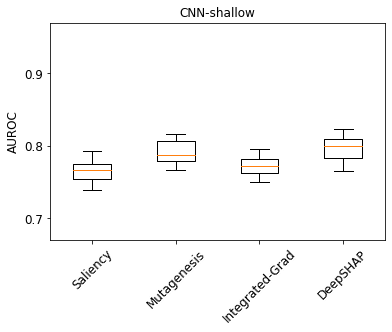

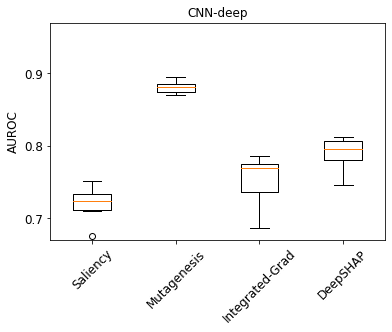

In [23]:
#fig = plt.figure(figsize=(10,3))
#plt.subplots_adjust(wspace=0.05, hspace=None)

score_names = ['saliency_scores1', 'mut_scores1', 'integrated_scores', 'shap_scores']
names = ['Saliency', 'Mutagenesis', 'Integrated-Grad', 'DeepSHAP']
activations = ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']

fig = plt.figure()
ax = plt.subplot(111)
score_name = 'saliency_scores1'
model_name = 'task2-cnn-shallow'
vals = []
for score_name in score_names:
    name = model_name+'_relu'
    vals.append(results[name][score_name][0])
    
ax.boxplot(vals);
plt.ylabel('AUROC', fontsize=12)
plt.yticks([0.7, 0.8, 0.9, 1.0], fontsize=12)
plt.xticks(range(1,5), names, fontsize=12, rotation=45)
ax.set_ybound([.67,.97])
plt.title('CNN-shallow', fontsize=12)

outfile = os.path.join(results_path, 'task2_compare_attr_score_activations_relu1')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

fig = plt.figure()
ax = plt.subplot(111)
model_name = 'task2-cnn-deep'
vals = []
for score_name in score_names:
    name = model_name+'_relu'
    vals.append(results[name][score_name][0])
    
ax.boxplot(vals);
plt.ylabel('AUROC', fontsize=12)
plt.yticks([0.7, 0.8, 0.9, 1.0], fontsize=12)
plt.xticks(range(1,5), names, fontsize=12, rotation=45)
ax.set_ybound([.67,.97])
plt.title('CNN-deep', fontsize=12)

outfile = os.path.join(results_path, 'task2_compare_attr_score_activations_relu2')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')



# Scatter plot relu vs exp

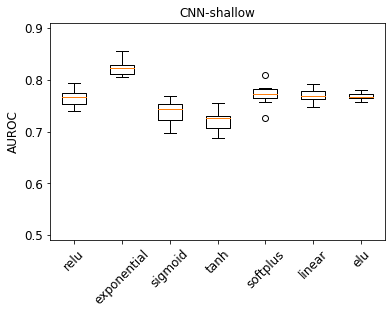

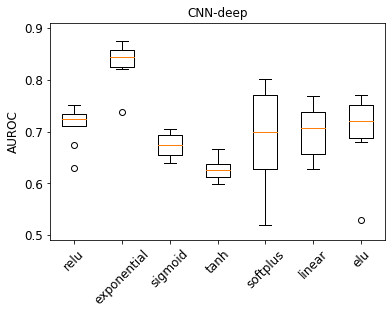

In [11]:
#fig = plt.figure(figsize=(10,3))
#plt.subplots_adjust(wspace=0.05, hspace=None)

activations = ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']

fig = plt.figure()
ax = plt.subplot(111)
score_name = 'saliency_scores1'
model_name = 'task2-cnn-shallow'
vals = []
for activation in activations:
    name = model_name+'_'+activation
    vals.append(results[name][score_name][0])
    
ax.boxplot(vals);
plt.ylabel('AUROC', fontsize=12)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=12)
plt.xticks(range(1,8), activations, fontsize=12, rotation=45)
ax.set_ybound([.49,0.91])
plt.title('CNN-shallow', fontsize=12)

outfile = os.path.join(results_path, 'task2_compare_attr_score_activations1')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

fig = plt.figure()
ax = plt.subplot(111)
model_name = 'task2-cnn-deep'
vals2 = []
for activation in activations:
    name = model_name+'_'+activation
    vals2.append(results[name][score_name][0])
    
ax.boxplot(vals2);
plt.ylabel('AUROC', fontsize=12)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=12)
#ax.tick_params(labelleft=False) 
plt.xticks(range(1,8), activations, fontsize=12, rotation=45);
ax.set_ybound([.49,0.91])
plt.title('CNN-deep', fontsize=12)

outfile = os.path.join(results_path, 'task2_compare_attr_score_activations2')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')



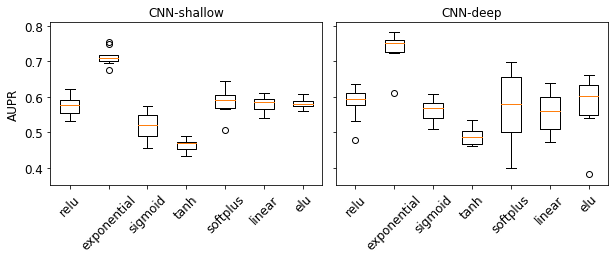

In [6]:
fig = plt.figure(figsize=(10,3))
plt.subplots_adjust(wspace=0.05, hspace=None)


ax = plt.subplot(1,2,1)
score_name = 'saliency_scores1'
model_name = 'task2-cnn-shallow'
vals = []
for activation in activations:
    name = model_name+'_'+activation
    vals.append(results[name][score_name][1])
    
ax.boxplot(vals);
plt.ylabel('AUPR', fontsize=12)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=12)
plt.xticks(range(1,8), activations, fontsize=12, rotation=45)
ax.set_ybound([.35,0.81])
plt.title('CNN-shallow', fontsize=12)

ax = plt.subplot(1,2,2)
model_name = 'task2-cnn-deep'
vals2 = []
for activation in activations:
    name = model_name+'_'+activation
    vals2.append(results[name][score_name][1])
    
ax.boxplot(vals2);
ax.tick_params(labelleft=False) 
plt.xticks(range(1,8), activations, fontsize=12, rotation=45);
ax.set_ybound([.35,0.81])


plt.title('CNN-deep', fontsize=12)
outfile = os.path.join(results_path, 'task2_compare_attr_score_activations_pr')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

# Plot compares cnn-shallow and cnn-deep for saliency

In [9]:
name

'task2-cnn-deep_elu'

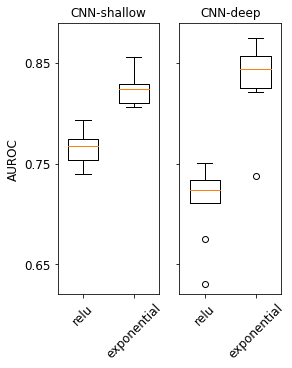

In [84]:
plot_activations =  ['relu', 'exponential']

fig = plt.figure(figsize=(4,5))
ax = plt.subplot(1,2,1)
score_name = 'saliency_scores1'
model_name = 'task2-cnn-shallow'
vals = []
for activation in plot_activations:
    name = model_name+'_'+activation
    vals.append(results[name][score_name][0])
    
ax.boxplot(vals,  widths = 0.6);
plt.ylabel('AUROC', fontsize=12)
plt.yticks([0.65, 0.75, 0.85], fontsize=12)
plt.xticks(range(1,3), plot_activations, fontsize=12, rotation=45)
ax.set_ybound([.62,0.89])
plt.title('CNN-shallow', fontsize=12)

ax = plt.subplot(1,2,2)
model_name = 'task2-cnn-deep'
vals2 = []
for activation in plot_activations:
    name = model_name+'_'+activation
    vals2.append(results[name][score_name][0])
    
ax.boxplot(vals2,  widths = 0.6);
#plt.ylabel('AUROC', fontsize=12)
plt.yticks([0.65, 0.75, 0.85], fontsize=12)
ax.tick_params(labelleft=False) 
plt.xticks(range(1,3), plot_activations, fontsize=12, rotation=45);
ax.set_ybound([.62,0.89])
plt.title('CNN-deep', fontsize=12)
outfile = os.path.join(results_path, 'task2_compare_attr_score_relu_exp')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
